In [1]:
import pandas as pd
import numpy as np
import gzip
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean, cityblock
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# Toggle on-off code text  
# from IPython.display import HTML

df_listings = pd.read_csv('singapore_listings_20190318.csv', low_memory=True).drop(columns='Unnamed: 0')

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()">
# <input type="submit" value="Click to toggle on/off the raw code.">
# </form>''')

<img src="./sg.jpg" height=500 width=1000>

# AirBnB @ Singapore: Exploring Traveller Segments in SG

## 1 Executive Summary

This part should include the following:
- summary 
- convincing motivation for the study
- methodoloy
    - data source, description and preprocessing pipeline
    - clustering method
    - validation methtods
    - selection of best k
- results
- conclusion and recommendation

## 2 Introduction

In this part include the following:
- why cluster air bnb listings?
- what is the main problem statement
- use cases on customer segmentation
- expound on the motivation
- what is the business value?
- What do we want to answer in this study?
- scope and limitations
- assumptions

## 3 Data Scope and Description

In this part, perform summary statistics to describe the data.
- scope of data
- summary statistics per features
- data types: nominal, categorial, ordinal, numerical
- what are the features present in the data set
- description of each feature
- how many instances are there?
- what is the relevance of each feature?
- data source

In [2]:
## selection of relevant features

data = df_listings[['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
            'bed_type', 'amenities', 'price', 'minimum_nights', 
            'instant_bookable',
            'neighborhood_overview']].copy()

## 4 Imputation, Outliers, and Multivariate Data Analysis

- multivariate analysis
- handling of outliers
- handling of missing data
- imputation

**Converting `Price` into Numeric**

In [3]:
## concert price into float

def convert(x):
    try:
        return int(x.strip('$').split('.')[0].split(',')[0])*1000+int(x.strip('$').split('.')[0].split(',')[1])
    except IndexError:
        return int(x.strip('$').split('.')[0])

data['price'] = data['price'].apply(lambda x: convert(x))

**Treatment of Missing Values**

The following columns shown in Table N.n have missing values. The type of imputation or handling for each is discussed below.

**Table N.n** Features with Values 

In [4]:
na = data.isna().sum()[data.isna().sum()>0].to_frame()
na.columns = ['Number of Missing Values']
display(na)

,Number of Missing Values
bathrooms,6
bedrooms,6
beds,15
neighborhood_overview,3234


*Feature: Bathroom*<br><br>
From Figure N.n, more than 70% of the values of the feature_bathroom is 1, having 5000 occurances. The next most frequent value is 2 with 1500 occurances. Thus, missing values were imputed by the most frequent value, which is 1. Since there are only 6 missing values, the maximum possible error due to this imputation would only be **<0.1%**.

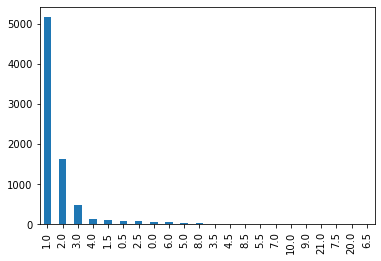

In [5]:
data['bathrooms'].value_counts().plot(kind='bar')
data['bathrooms'].fillna(data['bathrooms'].value_counts().index[0], inplace=True)

*Feature: bedrooms*<br><br>
From Figure N.n, more than 60% of the values of the feature_bedhroom is 1, having 5000 occurances. The next most frequent value is 2 with 1400 occurances. The third and fourth most frequent values are 0 and 3, with <1000 occurances. Thus, missing values were imputed by the most frequent value, which is 1. Since there are only 6 missing values, the maximum possible error due to this imputation would only be **<0.1%**.

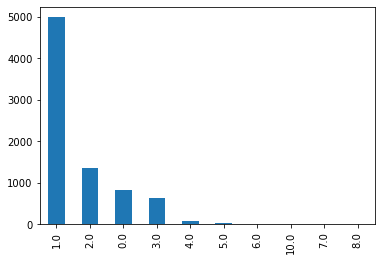

In [6]:
data['bedrooms'].value_counts().plot(kind='bar')
data['bedrooms'].fillna(data['bedrooms'].value_counts().index[0], inplace=True)

*Feature: beds*<br><br>
From Figure N.n, more than 50% of the values of the feature_bedhroom is 1, having 4500 occurances. The next most frequent value is 2 with 1800 occurances. The third and fourth most frequent values are 3 and 4, with <1000 occurances. Thus, missing values were imputed by the most frequent value, which is 1. Since there are only 15 missing values, the maximum possible error due to this imputation would only be **<0.2%**.

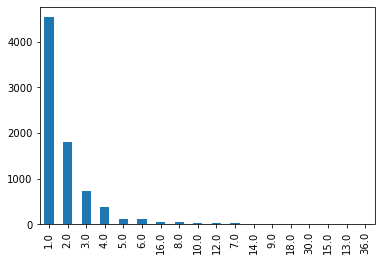

In [7]:
data['beds'].value_counts().plot(kind='bar')
data['beds'].fillna(data['beds'].value_counts().index[0], inplace=True)

*Feature: Neighborhood Overview*<br><br>
The  values under the neighborhood overview are the descriptions in text form. Thus, missing values would not be imputed by any method. Instead, missing values were replaced by empty sring `""` to be consistent with the data type of other values under this feature.

In [8]:
data['neighborhood_overview'].sample(5)
data['neighborhood_overview'].fillna('', inplace=True)

**Handling of Outliers**

Non integral values were observed under the feature `bathrooms`. The feature should contain only counting numbers but floating decimals were observed such as 1.5, 0.5, 8.5, etc. Thus, floating values will be rounded up to the nearest integer. 

In [9]:
print('Before: ', np.unique(data['bathrooms']))
data['bathrooms'] = data['bathrooms'].transform(np.ceil)
print('After: ', np.unique(data['bathrooms']))

Before:  [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.  10.  20.  21. ]
After:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 20. 21.]


The boxplots of each numerical features are shown below. The features `accomodates`, and `bedrooms` have relativelygood distribution. On the other hand, the features `bathrooms`, `beds` and `minimum_nights` seems to have some outliers. For objectivity, IQR method with 2.5 factor threshold was used to filter out the outliers. Using the IQR method, a total of ** number of outliers were removed, which is around x% of the dataset [B]. The boxplots of the numerical features after removing the outliers are shown in Figure N.n. Based on the figure, most of the data on the upper extremities were removed.

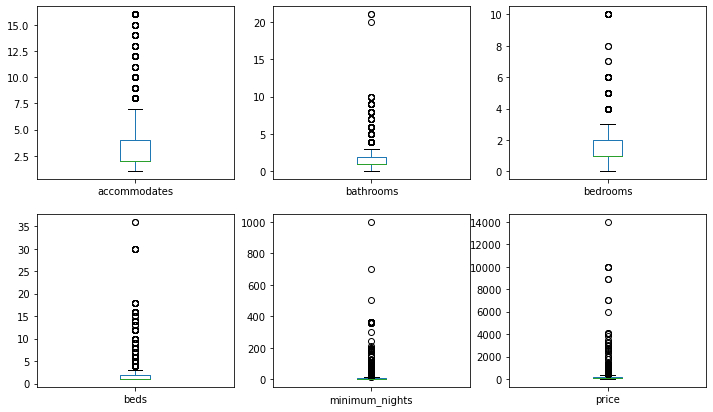

In [10]:
col_list = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'price']
fig, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 7))
ax_list = [ax1, ax2, ax3, ax4,ax5, ax6]
for i in range(len(col_list)):
    data[col_list[i]].plot(kind='box', ax=ax_list[i])

In [11]:
print('Size before removing outliers: ', data.shape)
for i in range(len(col_list)):
    # calculate interquartile range
    col_name25 = 'q25_' + col_list[i]
    data[col_name25] = np.percentile(data[col_list[i]], 25)

    col_name75 = 'q75_' + col_list[i]
    data[col_name75] = np.percentile(data[col_list[i]], 75)
    
    # calculate the outlier cutoff
    col_namecut = 'cut_' + col_list[i]
    data[col_namecut] = (data[col_name75] - data[col_name25])*4

    col_namelow = 'low_' + col_list[i]
    data[col_namelow] = data[col_name25] - data[col_namecut] 

    col_nameup = 'up_' + col_list[i]
    data[col_nameup] = data[col_name75] + data[col_namecut] 
    
    # identify outliers
    col_nameout = 'out_' + col_list[i]
    data[col_nameout] = (data[col_list[i]] < data[col_namelow])  | (data[col_list[i]] > data[col_nameup])

    data.drop(columns=[col_name25, col_name75, col_namecut, col_namelow, col_nameup], inplace=True)

data['sum'] = data[['out_' + col_list[i] for i in range(len(col_list))]].sum(axis=1) > 0

# remove outliers
data = data.loc[~data['sum']].iloc[:, :-7].copy()

print('Size after removing outliers: ', data.shape)


Size before removing outliers:  (7975, 12)
Size after removing outliers:  (6864, 12)


In [12]:
# data

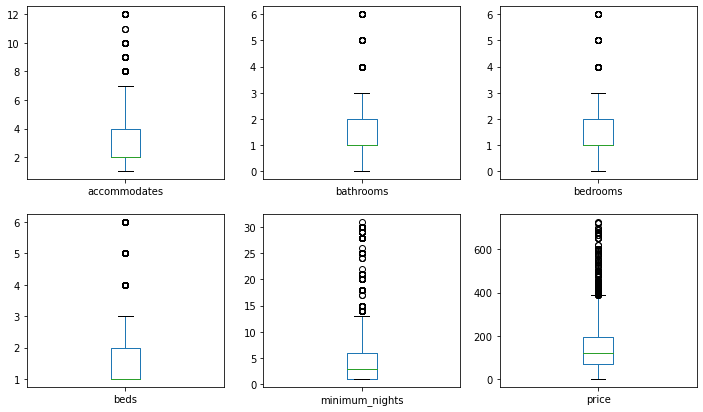

In [13]:
fig, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 7))
ax_list = [ax1, ax2, ax3, ax4,ax5, ax6]
for i in range(len(col_list)):
    data[col_list[i]].plot(kind='box', ax=ax_list[i])

**Multivariate Analysis**

The heatmap presented in Figure N.n shows partial collinearities between the following features: `accommodates`, `bedrooms`, `bathrooms`, and `beds`. The strongest linear correlation was observed on beds vs acccomodates. As expected, these features would have some degree of collinearity since the capacity to acccomodate means more bedrooms and beds. In order to eliminate collinearities, variance inflation factors (VIF) were calculated. The VIF factor measure the increase in the variance of the parameter estimate if an additional variable is added to a linear regression. Thus, a high VIF factor is indicative of high degree of collinearity.

The highest VIF factor was obtained for the feature `accommodates` (Table N.n). Typically, a VIF of $>10$ indicates high collinearity. Thus, the feature `accommodates` will be removed from the dataset. The new calculated VIFs are now given in Table N.n.

(6.5, -0.5)

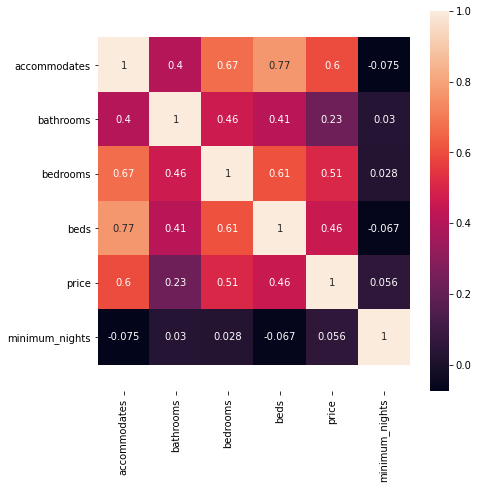

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(data.corr(), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [15]:
# vif(data, 'minimum_nights')
# data['minimum_nights']
X =  data[col_list]
X.values
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,12.164570,accommodates
1,4.698083,bathrooms
2,7.364864,bedrooms
3,9.035453,beds
4,1.461954,minimum_nights
5,4.822069,price


In [16]:
X =  data[col_list].drop(columns='accommodates')
X.values
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,4.653585,bathrooms
1,6.769421,bedrooms
2,5.976610,beds
3,1.447731,minimum_nights
4,4.107056,price


In [17]:
data.drop(columns='accommodates', inplace=True)

In [18]:
# data['amenities']

In [19]:
# data_subset = data[col_list[0]].values
# print('Size before removing outliers: ', data.shape)
# lof = LocalOutlierFactor(contamination=0.1)
# yhat = lof.fit_predict(data_subset)
# mask = yhat != -1
# data_clean = pd.DataFrame(data.values[mask])
# data_clean.columns = data.columns
# print('Size after removing outliers: ', data_clean.shape)
# data1 = pd.concat([data_clean, data.drop(columns=col_list)], axis=1)

In [20]:
# data_subset = data[col_list[0]].values.reshape(-1,1)
# # print('Size before removing outliers: ', data.shape)
# lof = LocalOutlierFactor(contamination=0.1)
# yhat = lof.fit_predict(data_subset)
# mask2 = yhat == -1
# data_clean = pd.DataFrame(data.values[mask2])
# data_clean.columns = data.columns

# data1 = pd.concat([data_clean, data.drop(columns=col_list)], axis=1)
# data_clean

In [21]:
# col_list = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights']
# fig, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 7))
# ax_list = [ax1, ax2, ax3, ax4,ax5, ax6]
# for i in range(len(col_list)):
#     data_clean[col_list[i]].plot(kind='box', ax=ax_list[i])

## 5 Exploratory Data Analysis

In [22]:
data.isna().sum().sum()

0

## 6 Feature Engineering

- log transformation
- feature crossing
- feature selection
- bias removal
- dimensionality reduction
- one hot encoding
- feature mapping
- scaling

**Vectorization of Categorical Features**

The values under the feature `amenities` are given as string enclosed in braces `{`, `}`. Thus, in order to extract the relevant information, these values were stripped, tokenized and vectorized based on their respective frequencies (Bag-of-Words representation). NaN values were replaced by 0. This vectorization resulted to additional 195 columns in the data frame.

The values under the feature `neighborhood_overview` are also given as list of strings. Thus, the same method was employed to extract the relevant information. That is, the values were stripped, tokenized and vectorized based on their respecttive frequencies. NaN values were replaced by 0. This vectorization resulted to additional 195 columns in the data frame.

In [157]:
## vectorize amenities

irr_words = ['the', 'and', 'to', 'of', 'in', 'is', 'a', 'from', 'for', '-', 
             'are', 'at', 'etc', 'or', '&', 'that', 'will', 'an', 'with', 
             'as', '2', 'it', 'premises', 'allowed', 'be', 'head', 'on', 
             'tanjong', 'can', 'located', 'just', 'not', 'min', 'tiong', 
             'many', 'within', 'first', 'self', 'by', 'there', 'we', 
             'on', 'check', 'about', 'out', 'bharu', 'translation', 'you', '/', 'off']

irr_words_col = ['amenities_' + word for word in irr_words] + ['amenities']

def to_bow(docs):
    my_list = [dict(Counter(doc.lower().split())) for doc in docs]
    df = pd.DataFrame(my_list).fillna(0)
    return df.reindex(sorted(df.columns), axis=1)

stripped = [string.strip('{').strip('}').split(',') for string in list(data['amenities'].values)]

stripped_list = []
for group in stripped:
        stripped_list.append([word.strip('''"''').strip("'") for word in group])
        
bow_list_amenities = []
for group in stripped_list:
    bow_list_amenities.append(to_bow(group).sum())
    
cat_amenities = pd.concat(bow_list_amenities, axis=1).fillna(0)
cat_amenities = cat_amenities.T.copy()
cat_amenities.columns = ['amenities_'+name for name in cat_amenities.columns.to_list()]
data1 = pd.concat([data.reset_index(drop=True), cat_amenities.reset_index(drop=True)], axis=1)

for col in irr_words_col:
    try:
        data1.drop(columns=col, inplace=True)
    except KeyError:
        continue

In [158]:
## vectorize neighborhood overview
irr_words_col_neigh = ['neighborhood_overview_' + word for word in irr_words] + ['neighborhood_overview']

stripped_neigh = data1['neighborhood_overview'].to_list()

text_list = [text.split(' ') for text in stripped_neigh]

group_list = []
for group in text_list:
    group_list.append([word.strip().strip("'").strip('''"''').strip('.').strip('(').strip(')').strip('!') for word in group])

bow_list_neigh = []
for group in group_list:
    bow_list_neigh.append(to_bow(group).sum())
    
cat_neigh = pd.concat(bow_list_neigh, axis=1).T.fillna(0)

cat_neigh.columns = ['neighborhood_overview_'+name for name in cat_neigh.columns.to_list()]
data2 = pd.concat([data1.reset_index(drop=True), cat_neigh.reset_index(drop=True)], axis=1)
for col in irr_words_col_neigh:
    try:
        data2.drop(columns=col, inplace=True)
    except KeyError:
        continue

In [103]:
# data2.columns.to_list()

**Log Transformation**

Some features are highly skewed as observed in the multivariate analysis. In these features, logarithmic transformation was used to reduce the variable and make the data more conforming to normal distribution [B]. The transformation takes the form

$$
f(x) = \log{(x+1)}
$$

Based on the density plots, the dsitribution became closer to normal distribution after log-transformation.

**Figure N.n Comparison of Density Plots of 

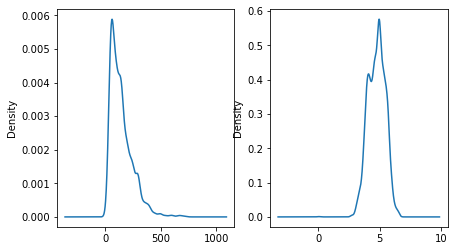

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,4))
data2['price'].plot(kind='density', ax=ax1)
data2['log_price'] = (data2['price'] + 1).transform(np.log)
data2.drop(columns='price', inplace=True)
data2['log_price'].plot(kind='density', ax=ax2)

**One-Hot Encode Nominal Categorical Features**

The nominal categorical features such as `property_type`, `room_type`, `bed_type`and `instant_bookable` were one-hot encoded and the last column was dropped to reduce the number of dimensions. This would not result to information loss since for one-hot encoding, there is at least one feature that is lineary dependent to the rest of the features. 

In [105]:
## one-hot encode nominal categorical features
cols = [col + '_' + data2[col].unique()[0] for col in ['property_type', 'room_type', 'bed_type', 'instant_bookable']]
X = pd.get_dummies(data2).drop(columns=cols)

**Numerical Features Scaling by Standization**

Numerical features such as 'log_price', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights' will be scaled by standardization. The advantage of standardizing these features is to align orders of magnitude for distance computation in the clustering algorithm.

In [45]:
# numerical_features = ['log_price', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights']
# X_scaled = StandardScaler().fit_transform(X)

In [48]:
X_scaled.shape

(6864, 9020)

In [ ]:
X_scaled

**Feature Selection Using VarianceThreshold**

To select only the important features, especially for one-hot encoded Bag-of-Words representations of `neighborhood_overview` and `amenities`, the variance threshold was used to filter out features where a single value is more than 80% of the whole set. This is useful to remove `neighborhood_overview` sub-features with only 1-2 instances in the whole data set.

In [122]:
# set the variance threshold

p = 0.9
sel = VarianceThreshold(threshold=(p * (1 - p)))
X_reduced = sel.fit_transform(X.values)
print('Size before Variance Threshold reduction: ', X.values.shape)
print('Size after Variance Threshold reduction: ', X_reduced.shape)

Size before Variance Threshold reduction:  (6864, 8962)
Size after Variance Threshold reduction:  (6864, 165)


In [55]:
# X

## 7 Clustering

- clustering methods
- selection of best k
- validation

**KMeans Clustering**

In [123]:
def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    Q_j = np.zeros(len(np.unique(y)))
    for index, cluster_i in enumerate(y):
        Qj_col = {v: k for k, v in enumerate(np.unique(y))}
        Q_j[Qj_col[cluster_i]] += dist(X[index, :], centroids[cluster_i, :])**2
    return sum(0.5*Q_j/np.unique(y, return_counts=True)[1])

def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    """Compute the gap statistic
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(random_state)
    W_ki = []
    for i in range(b):
        distribution = rng.uniform(X.min(0), X.max(0), X.shape)
        realizations = clusterer.fit_predict(distribution)
        W_ki.append(np.log(pooled_within_ssd(distribution, realizations, 
                                             clusterer.cluster_centers_, 
                                             dist)))
    E_logWk = np.mean(W_ki)
    Gap = E_logWk - np.log(pooled_within_ssd(X, y, centroids, dist))
    return Gap, np.std(W_ki)

inertia = []
CH = []
SC= []
GS = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced)
    y_pred = km.predict(X_reduced)
    inertia.append(km.inertia_)
    CH.append(calinski_harabasz_score(X_reduced, y_pred))
    SC.append(silhouette_score(X_reduced, y_pred))
    GS.append(gap_statistic(X_reduced, y_pred, km.cluster_centers_, euclidean, len(np.unique(y_pred)), KMeans(n_clusters=k))[0])

**Selection of Best k**

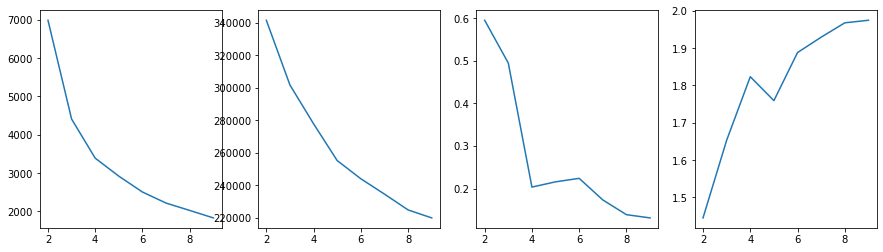

In [124]:
## check the trend of scores

## from SC and GS, k=4

scores_df = pd.DataFrame([inertia, CH, SC, GS]).T
scores_df.columns = ['inertia', 'CH', 'SC', 'GS']
scores_df.index = range(2,10)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,4))
scores_df['CH'].plot(kind='line', ax=ax1)
scores_df['inertia'].plot(kind='line', ax=ax2)
scores_df['SC'].plot(kind='line', ax=ax3)
scores_df['GS'].plot(kind='line', ax=ax4)

*Singular Value Decomposition for Plotting**

In [161]:
## Plot the clusters
## transform data into 2d using truncated svd

X_trunc = (TruncatedSVD(n_components=2)
                    .fit_transform(X_reduced))
y_pred_list = []
for k in range(3, 7):
    km = KMeans(n_clusters=k, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced)
    y_pred_list.append(km.predict(X_reduced))

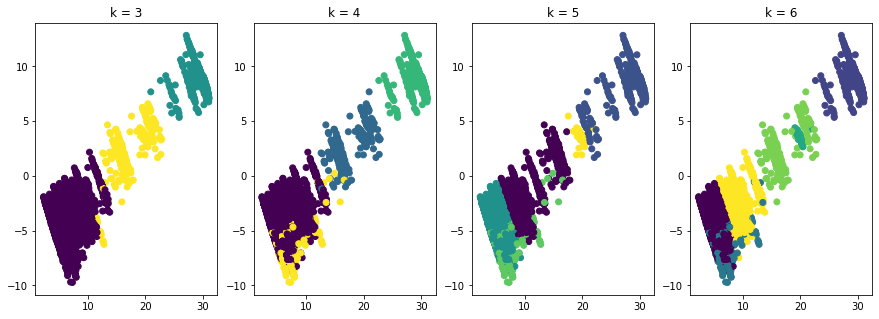

In [163]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(15, 5))
ax_list = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax_list[i].scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[i])
    ax_list[i].set_title(f'k = {i+3}')

**Idenification of Top Features**

In [125]:
## rank features according to importance

km = KMeans(n_clusters=4, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced)
scores_list_bestk = []
bestk = SelectKBest(score_func=mutual_info_classif, k='all')
bestk.fit(X_reduced, km.predict(X_reduced))
scores_list_bestk.append(bestk.scores_)

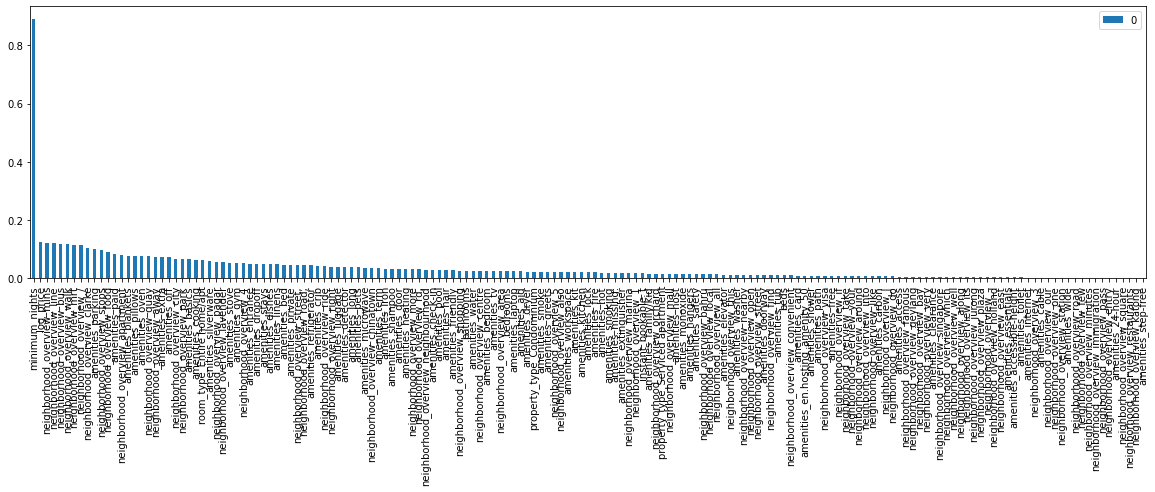

In [126]:
feature_rank_df = pd.DataFrame(scores_list_bestk)
feature_rank_df.columns = np.array(X.columns)[sel.get_support()]
feature_rank_df.T.sort_values(by=0, ascending=False).plot(kind='bar', figsize=(20,5))

In [156]:
## Top 10 Features
feature_rank_df.T.sort_values(by=0, ascending=False).index.to_list()[:25]

['minimum_nights',
 'log_price',
 'neighborhood_overview_mins',
 'neighborhood_overview_line',
 'neighborhood_overview_bus',
 'neighborhood_overview_walk',
 'neighborhood_overview_mrt',
 'neighborhood_overview_/',
 'neighborhood_overview_clarke',
 'amenities_parking',
 'neighborhood_overview_stops',
 'neighborhood_overview_food',
 'amenities_paid',
 'neighborhood_overview_apartment',
 'amenities_blankets',
 'amenities_pillows',
 'amenities_oven',
 'neighborhood_overview_quay',
 'neighborhood_overview_away',
 'amenities_extra',
 'amenities_off',
 'neighborhood_overview_city',
 'neighborhood_overview_park',
 'amenities_basics',
 'amenities_cooking']

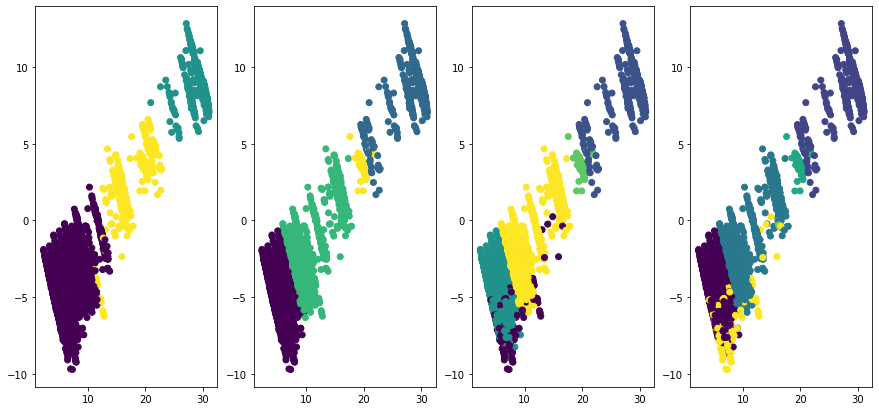

In [129]:
y_pred_list_agg = []
for k in range(3, 7):
    agc = AgglomerativeClustering(n_clusters=k, linkage='average').fit_predict(X_reduced)
    y_pred_list.append(agc)

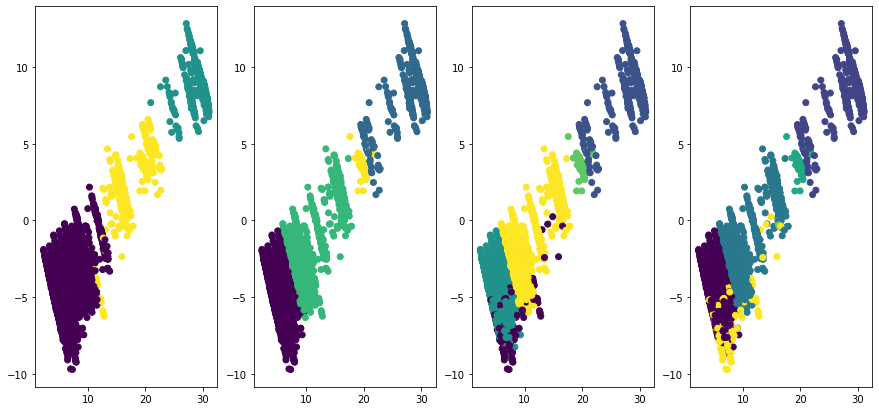

In [130]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(15, 7))
ax1.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[0])
ax2.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[1])
ax3.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[2])
ax4.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[3])

## 8 Cluster Analysis and Exploration

In [133]:
## exploring the customer segments

predicted_data = data2.copy()
predicted_data['segment'] = y_pred_list[1]
predicted_data['price'] = predicted_data['log_price'].apply(lambda x: np.exp(x)-1)

segment_0 = predicted_data[predicted_data['segment']==0]
segment_1 = predicted_data[predicted_data['segment']==1]
segment_2 = predicted_data[predicted_data['segment']==2]
segment_3 = predicted_data[predicted_data['segment']==3]

**Minimum Nights**

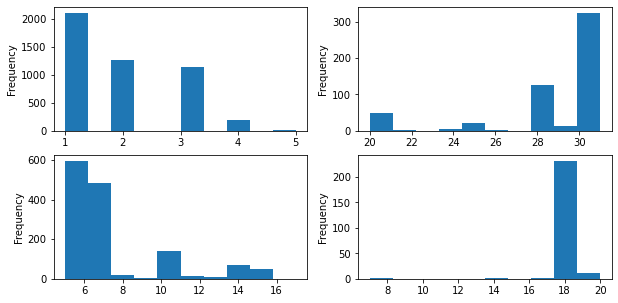

In [135]:
## explore differences in minimum nights of different segments

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))
ax_list = [ax1, ax2, ax3, ax4]

for i in range(4):
    predicted_data[predicted_data['segment']==i]['minimum_nights'].plot(kind='hist', ax=ax_list[i])

**How Segments Differ in Pricing**

segment
0    140.787415
1    177.119626
2    161.324383
3     51.672065
Name: price, dtype: float64

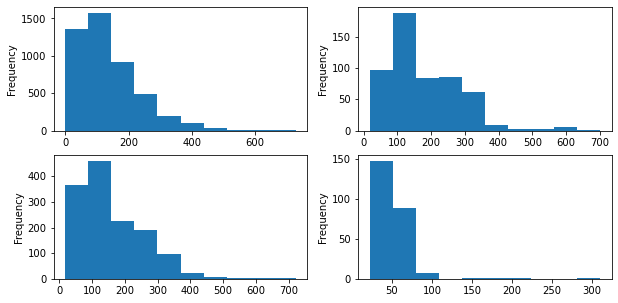

In [136]:
## explore price differences of different segments

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))
ax_list = [ax1, ax2, ax3, ax4]

for i in range(4):
    predicted_data[predicted_data['segment']==i]['price'].plot(kind='hist', ax=ax_list[i])
    
predicted_data.groupby('segment')['price'].mean()

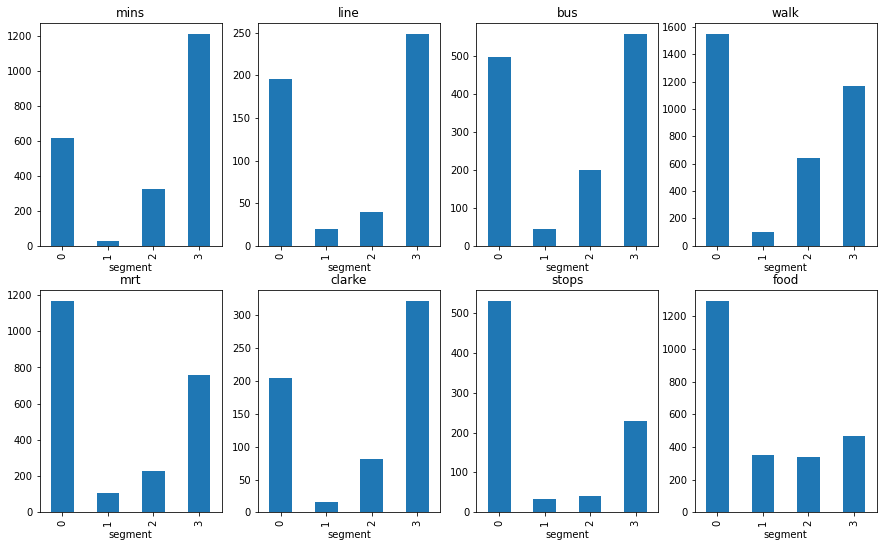

In [155]:
## explore differences in neighborhood overview at different segments
neighborhood = ['neighborhood_overview_mins', 'neighborhood_overview_line',
 'neighborhood_overview_bus',
 'neighborhood_overview_walk',
 'neighborhood_overview_mrt', 'neighborhood_overview_clarke', 
                'neighborhood_overview_stops', 'neighborhood_overview_food']

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(15,9))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(len(neighborhood)):
    predicted_data.groupby('segment')[neighborhood[i]].sum().plot(kind='bar', ax=ax_list[i])
#     ax_list[i].set_xlabel(rotation='horizontal')
    ax_list[i].set_title(neighborhood[i].split('_')[-1])

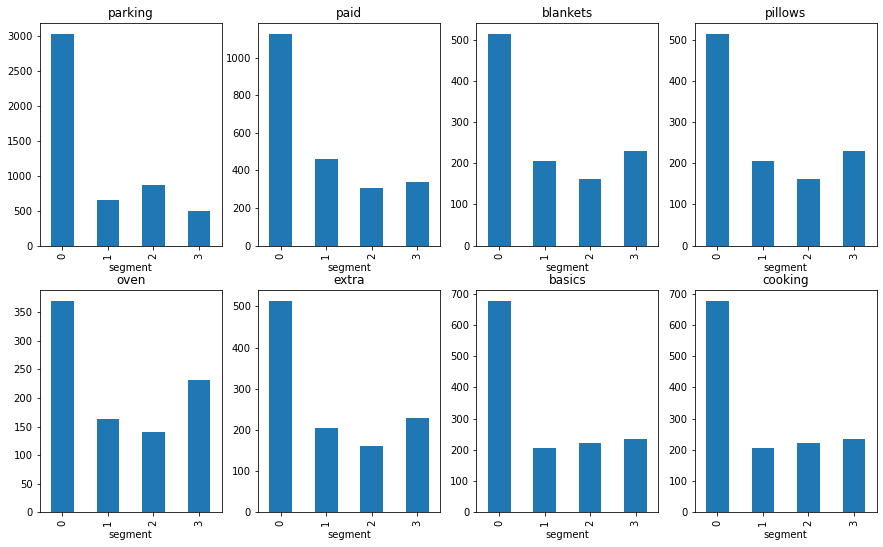

In [160]:
## explore differences in amenities at different segments

amenities = ['amenities_parking',
 'amenities_paid',
 'amenities_blankets',
 'amenities_pillows',
 'amenities_oven',
 'amenities_extra',
 'amenities_basics',
 'amenities_cooking']
             
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(15,9))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(len(amenities)):
    predicted_data.groupby('segment')[amenities[i]].sum().plot(kind='bar', ax=ax_list[i])
#     ax_list[i].set_xlabel(rotation='horizontal')
    ax_list[i].set_title(amenities[i].split('_')[-1])

## 9 Conclusion

## 10 Recommendation

## 11 Bibliography

In [14]:
# f_path = '/mnt/data/public/insideairbnb/data.insideairbnb.com/singapore/sg/singapore/2019-03-18/data/listings.csv.gz'
# with gzip.open(f_path, 'r') as f:
df_listings = pd.read_csv('singapore_listings_20190318.csv')

In [15]:
## selection of relevant features

data = df_listings[['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
            'bed_type', 'amenities', 'price', 'minimum_nights', 
            'instant_bookable',
            'neighborhood_overview']].copy()

In [16]:
## check for NAs

data.isna().sum()

property_type               0
room_type                   0
accommodates                0
bathrooms                   6
bedrooms                    6
beds                       15
bed_type                    0
amenities                   0
price                       0
minimum_nights              0
instant_bookable            0
neighborhood_overview    3234
dtype: int64

In [17]:
## impute NA values
## beds : most freq
## neighborhood_overview by empty string

data['beds'].fillna(data['beds'].value_counts().index[0], inplace=True)
data['neighborhood_overview'].fillna('', inplace=True)

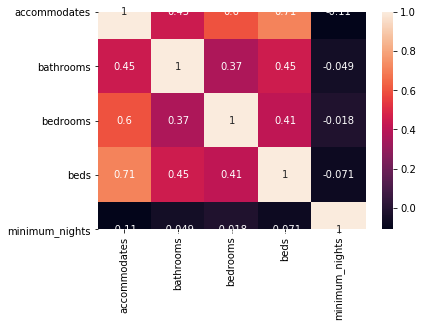

In [18]:
## check for collinearity

sns.heatmap(data.corr(), annot=True)

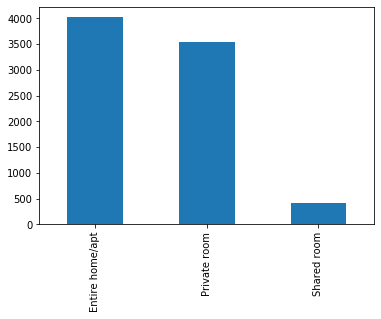

In [19]:
## remove possible outliers and bias

data['room_type'].value_counts().plot(kind='bar')

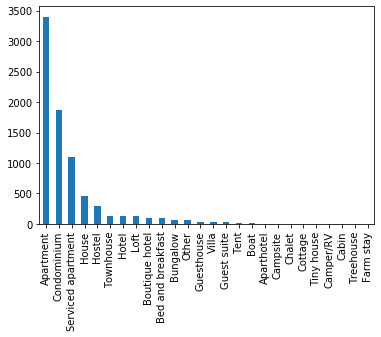

In [20]:
data['property_type'].value_counts().plot(kind='bar')

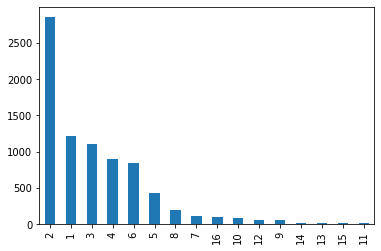

In [21]:
data['accommodates'].value_counts().plot(kind='bar')

In [22]:
data['bathrooms'].fillna(data['bathrooms'].value_counts().index[0], inplace=True)

In [23]:
data['bedrooms'].fillna(data['bedrooms'].value_counts().index[0], inplace=True)

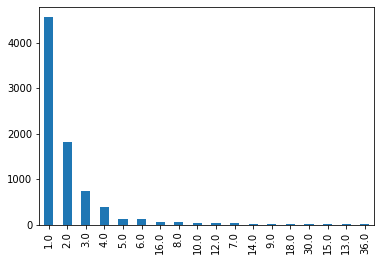

In [24]:
data['beds'].value_counts().plot(kind='bar')

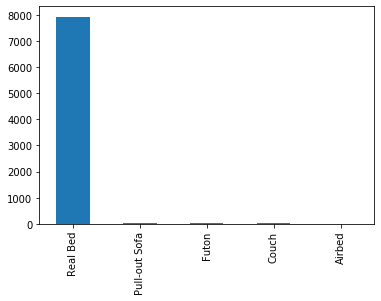

In [25]:
data['bed_type'].value_counts().plot(kind='bar')

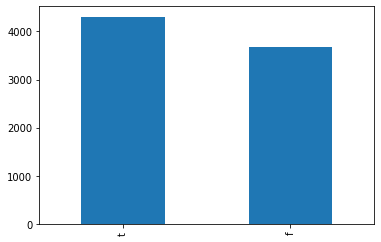

In [26]:
data['instant_bookable'].value_counts().plot(kind='bar')

In [27]:
## vectorize amenities

def to_bow(docs):
    my_list = [dict(Counter(doc.lower().split())) for doc in docs]
    df = pd.DataFrame(my_list).fillna(0)
    return df.reindex(sorted(df.columns), axis=1)

stripped = [string.strip('{').strip('}').split(',') for string in list(data['amenities'].values)]
stripped_list = []
for group in stripped:
        stripped_list.append([word.strip('''"''').strip("'") for word in group])
        
bow_list_amenities = []
for group in stripped_list:
    bow_list_amenities.append(to_bow(group).sum())
    
cat_amenities = pd.concat(bow_list_amenities, axis=1).T.fillna(0)
cat_amenities.columns = ['amenities_'+name for name in cat_amenities.columns.to_list()]

data1 = pd.concat([data, cat_amenities], axis=1).drop(columns='amenities')

In [28]:
## concert price into float

def convert(x):
    try:
        return int(x.strip('$').split('.')[0].split(',')[0])*1000+int(x.strip('$').split('.')[0].split(',')[1])
    except IndexError:
        return int(x.strip('$').split('.')[0])

data1['price'] = data1['price'].apply(lambda x: convert(x))

In [29]:
## vectorize neighborhood overview

stripped_neigh = data1['neighborhood_overview'].to_list()

text_list = [text.split(' ') for text in stripped_neigh]

group_list = []
for group in text_list:
    group_list.append([word.strip().strip("'").strip('''"''').strip('.').strip('(').strip(')').strip('!') for word in group])

bow_list_neigh = []
for group in group_list:
    bow_list_neigh.append(to_bow(group).sum())
    
cat_neigh = pd.concat(bow_list_neigh, axis=1).T.fillna(0)

cat_neigh.columns = ['neighborhood_overview_'+name for name in cat_neigh.columns.to_list()]

data2 = pd.concat([data1, cat_neigh], axis=1).drop(columns='neighborhood_overview')

MemoryError: 

In [ ]:
## check for na values

data2.isna().sum().sum()

In [ ]:
## log-transform numerical features

data2['log_accommodates'] = (data2['accommodates']+1).transform(np.log)
data2['log_price'] =  (data2['price']+1).transform(np.log)

data2.drop(columns=['accommodates', 'price'], inplace=True)

In [ ]:
## one-hot encode nominal categorical features

X = pd.get_dummies(data2)

In [ ]:
## Scale the data

# X_scaled = StandardScaler().fit_transform(X)

In [ ]:
X.isna().sum().sum()

In [ ]:
p = 0.8
sel = VarianceThreshold(threshold=(p * (1 - p)))
X_reduced1 = sel.fit_transform(X)

In [ ]:
X_reduced1.shape
X.shape

In [ ]:
## First trial clustering
    
inertia = []
CH = []
SC= []
GS = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced1)
    y_pred = km.predict(X_reduced1)
    inertia.append(km.inertia_)
    CH.append(calinski_harabasz_score(X_reduced1, y_pred))
    SC.append(silhouette_score(X_reduced1, y_pred))

In [ ]:
## check the trend of scores

## from CH, k=6,
## from inertia, k=6
## from SC = k=5
scores_df = pd.DataFrame([inertia, CH, SC]).T
scores_df.columns = ['inertia', 'CH', 'SC']
scores_df.index = range(2,10)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
scores_df['CH'].plot(kind='line', ax=ax1)
scores_df['inertia'].plot(kind='line', ax=ax2)
scores_df['SC'].plot(kind='line', ax=ax3)

In [ ]:
## rank features according to importance

km = KMeans(n_clusters=6, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced1)
scores_list_bestk = []
bestk = SelectKBest(score_func=mutual_info_classif, k='all')
bestk.fit(X_reduced1, km.predict(X_reduced1))
scores_list_bestk.append(bestk.scores_)

In [ ]:
# np.array(X.columns)[sel.get_support()]

In [ ]:
feature_rank_df = pd.DataFrame(scores_list_bestk)
feature_rank_df.columns = np.array(X.columns)[sel.get_support()]
feature_rank_df.T.sort_values(by=0, ascending=False).plot(kind='bar', figsize=(20,5))

In [ ]:
## Plot the clusters
## transform data into 2d using truncated svd

X_trunc = (TruncatedSVD(n_components=2)
                    .fit_transform(X_reduced1))
y_pred_list = []
for k in range(4, 7):
    km = KMeans(n_clusters=k, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_reduced1)
    y_pred_list.append(km.predict(X_reduced1))

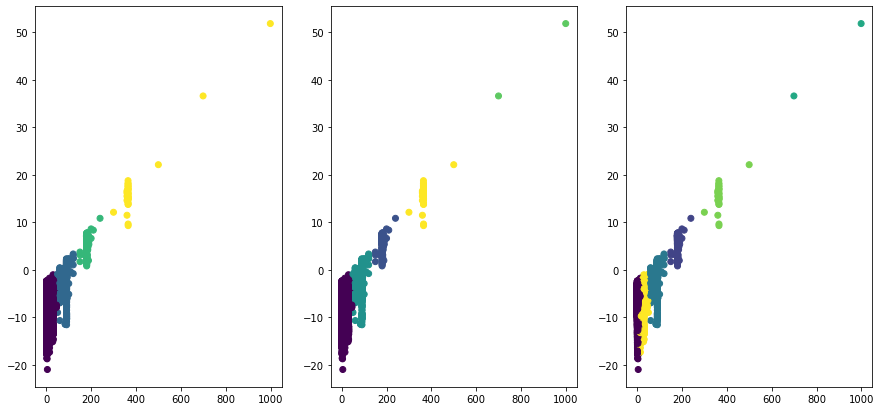

In [119]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
ax1.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[0])
ax2.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[1])
ax3.scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[2])

In [200]:
## exploring the customer segments

predicted_data = data2.copy()
predicted_data['segment'] = y_pred_list[2]
predicted_data['price'] = predicted_data['log_price'].apply(lambda x: np.exp(x)-1)
predicted_data['accommodates'] = predicted_data['log_accommodates'].apply(lambda x: np.exp(x)-1)
predicted_data.drop(columns=['log_price', 'log_accommodates'], inplace=True)

segment_0 = predicted_data[predicted_data['segment']==0]
segment_1 = predicted_data[predicted_data['segment']==1]
segment_2 = predicted_data[predicted_data['segment']==2]
segment_3 = predicted_data[predicted_data['segment']==3]
segment_4 = predicted_data[predicted_data['segment']==4]
segment_5 = predicted_data[predicted_data['segment']==5]

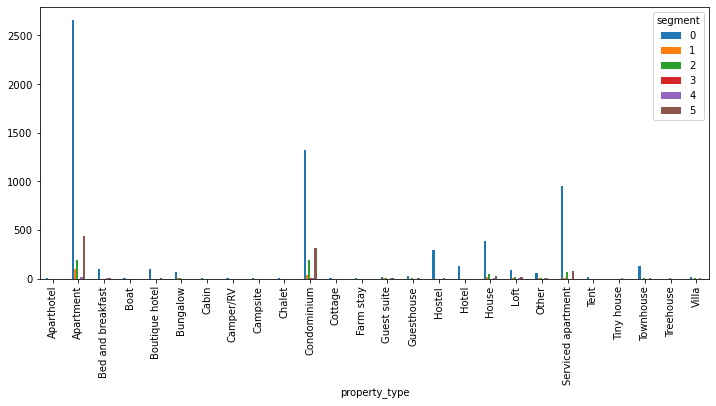

In [201]:
predicted_data.groupby('segment')['property_type'].value_counts().unstack().T.plot(kind='bar', figsize=(12,5))
# plot(kind='bar')

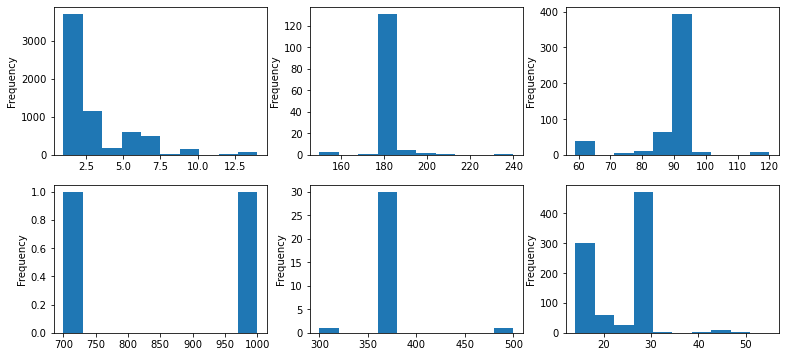

In [202]:
## explore differences in minimum nights of different segments

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(13,6))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(6):
    predicted_data[predicted_data['segment']==i]['minimum_nights'].plot(kind='hist', ax=ax_list[i])

segment
0    174.263578
1    107.069444
2    134.949153
3     94.000000
4    353.343750
5    150.656784
Name: price, dtype: float64

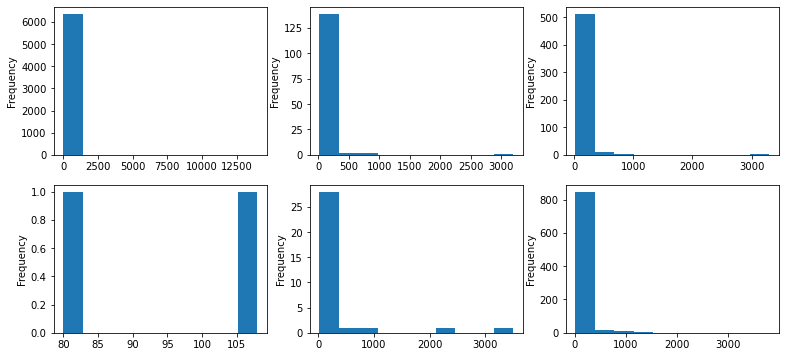

In [204]:
## explore price differences of different segments

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(13,6))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(6):
    predicted_data[predicted_data['segment']==i]['price'].plot(kind='hist', ax=ax_list[i])
    
predicted_data.groupby('segment')['price'].mean()

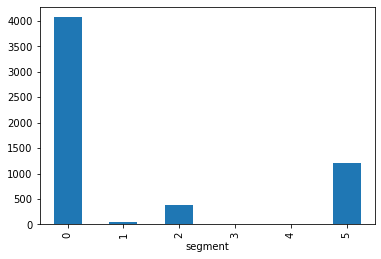

In [210]:
## explore differences in availability of parking at different segments

predicted_data.groupby('segment')['amenities_parking'].sum().plot(kind='bar')

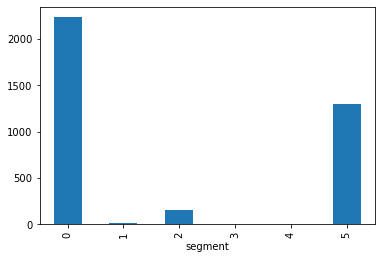

In [212]:
## explore differences in neighborhood overview at different segments

predicted_data.groupby('segment')['neighborhood_overview_min'].sum().plot(kind='bar')

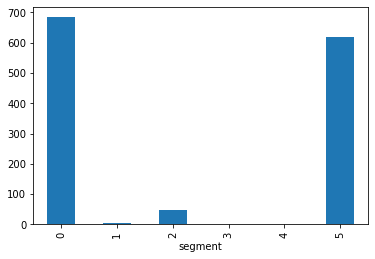

In [213]:
## explore differences in neighborhood overview at different segments

predicted_data.groupby('segment')['neighborhood_overview_bus'].sum().plot(kind='bar')

In [1]:
## explore differences in number of accomodations

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(13,6))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(6):
    predicted_data[predicted_data['segment']==i]['accommodates'].plot(kind='hist', ax=ax_list[i])

NameError: name 'plt' is not defined

[B] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/ <br>
[B] https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/